In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = PowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 37201 
    Total predicted counts          : 37349.54
    Total off counts                : 102118.00

    Total background counts         : 20423.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.75

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 5000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 22.1 s, sys: 114 ms, total: 22.2 s
Wall time: 22.2 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 37107 
    Total predicted counts          : 37257.94
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.87

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 36990 
    Total predicted counts          : 37192.34
    Total off counts                : 101332.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_21 

    Total counts                    : 36931 
    Total predicted counts          : 37335.74
    Total off counts                : 102049.00

    Total background counts         : 20409.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.38

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_22 

    Total counts                    : 37062 
    Total predicted counts          : 37205.14
    Total off counts                : 101396.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_44 

    Total counts                    : 37382 
    Total predicted counts          : 37299.74
    Total off counts                : 101869.00

    Total background counts         : 20373.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.57

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_45 

    Total counts                    : 37119 
    Total predicted counts          : 37229.34
    Total off counts                : 101517.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_64 

    Total counts                    : 37216 
    Total predicted counts          : 37230.14
    Total off counts                : 101521.00

    Total background counts         : 20304.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.39

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_65 

    Total counts                    : 36892 
    Total predicted counts          : 37123.34
    Total off counts                : 100987.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_86 

    Total counts                    : 37073 
    Total predicted counts          : 37211.54
    Total off counts                : 101428.00

    Total background counts         : 20285.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.72

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_87 

    Total counts                    : 37437 
    Total predicted counts          : 37240.34
    Total off counts                : 101572.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_108 

    Total counts                    : 37429 
    Total predicted counts          : 37267.74
    Total off counts                : 101709.00

    Total background counts         : 20341.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.75

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_109 

    Total counts                    : 37585 
    Total predicted counts          : 37207.54
    Total off counts                : 101408.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_129 

    Total counts                    : 37192 
    Total predicted counts          : 37226.74
    Total off counts                : 101504.00

    Total background counts         : 20300.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.12

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_130 

    Total counts                    : 37421 
    Total predicted counts          : 37283.54
    Total off counts                : 101788.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_150 

    Total counts                    : 37089 
    Total predicted counts          : 37235.54
    Total off counts                : 101548.00

    Total background counts         : 20309.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.06

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_151 

    Total counts                    : 37431 
    Total predicted counts          : 37269.54
    Total off counts                : 101718.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_171 

    Total counts                    : 37388 
    Total predicted counts          : 37280.74
    Total off counts                : 101774.00

    Total background counts         : 20354.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.91

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_172 

    Total counts                    : 36907 
    Total predicted counts          : 37255.34
    Total off counts                : 101647.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_193 

    Total counts                    : 37148 
    Total predicted counts          : 37261.14
    Total off counts                : 101676.00

    Total background counts         : 20335.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.19

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_194 

    Total counts                    : 37072 
    Total predicted counts          : 37257.54
    Total off counts                : 101658.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_214 

    Total counts                    : 36914 
    Total predicted counts          : 37198.54
    Total off counts                : 101363.00

    Total background counts         : 20272.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.93

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_215 

    Total counts                    : 37038 
    Total predicted counts          : 37304.34
    Total off counts                : 101892.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_236 

    Total counts                    : 37074 
    Total predicted counts          : 37200.14
    Total off counts                : 101371.00

    Total background counts         : 20274.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.72

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_237 

    Total counts                    : 37267 
    Total predicted counts          : 37192.14
    Total off counts                : 101331.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_256 

    Total counts                    : 37190 
    Total predicted counts          : 37380.34
    Total off counts                : 102272.00

    Total background counts         : 20454.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.77

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_257 

    Total counts                    : 37343 
    Total predicted counts          : 37194.94
    Total off counts                : 101345.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_277 

    Total counts                    : 37049 
    Total predicted counts          : 37269.54
    Total off counts                : 101718.00

    Total background counts         : 20343.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.46

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_278 

    Total counts                    : 37582 
    Total predicted counts          : 37319.74
    Total off counts                : 101969.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_298 

    Total counts                    : 37342 
    Total predicted counts          : 37082.34
    Total off counts                : 100782.00

    Total background counts         : 20156.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.69

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_299 

    Total counts                    : 37166 
    Total predicted counts          : 37145.14
    Total off counts                : 101096.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_319 

    Total counts                    : 37215 
    Total predicted counts          : 37224.94
    Total off counts                : 101495.00

    Total background counts         : 20299.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.25

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_320 

    Total counts                    : 37608 
    Total predicted counts          : 37206.34
    Total off counts                : 101402.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_352 

    Total counts                    : 37323 
    Total predicted counts          : 37125.94
    Total off counts                : 101000.00

    Total background counts         : 20200.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.19

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_353 

    Total counts                    : 36989 
    Total predicted counts          : 37387.54
    Total off counts                : 102308.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_386 

    Total counts                    : 37304 
    Total predicted counts          : 37133.34
    Total off counts                : 101037.00

    Total background counts         : 20207.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.73

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_387 

    Total counts                    : 37091 
    Total predicted counts          : 37263.74
    Total off counts                : 101689.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_423 

    Total counts                    : 37468 
    Total predicted counts          : 37290.34
    Total off counts                : 101822.00

    Total background counts         : 20364.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.74

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_424 

    Total counts                    : 37261 
    Total predicted counts          : 37157.34
    Total off counts                : 101157.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_460 

    Total counts                    : 37294 
    Total predicted counts          : 37310.54
    Total off counts                : 101923.00

    Total background counts         : 20384.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.10

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_461 

    Total counts                    : 36935 
    Total predicted counts          : 37298.34
    Total off counts                : 101862.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_497 

    Total counts                    : 37062 
    Total predicted counts          : 37289.74
    Total off counts                : 101819.00

    Total background counts         : 20363.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.00

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_498 

    Total counts                    : 37190 
    Total predicted counts          : 37223.94
    Total off counts                : 101490.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_532 

    Total counts                    : 37166 
    Total predicted counts          : 37313.14
    Total off counts                : 101936.00

    Total background counts         : 20387.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.16

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_533 

    Total counts                    : 36991 
    Total predicted counts          : 37258.14
    Total off counts                : 101661.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_568 

    Total counts                    : 37267 
    Total predicted counts          : 37183.94
    Total off counts                : 101290.00

    Total background counts         : 20258.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.93

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_569 

    Total counts                    : 37538 
    Total predicted counts          : 37230.54
    Total off counts                : 101523.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_605 

    Total counts                    : 37502 
    Total predicted counts          : 37249.34
    Total off counts                : 101617.00

    Total background counts         : 20323.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.92

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_606 

    Total counts                    : 37149 
    Total predicted counts          : 37186.54
    Total off counts                : 101303.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_637 

    Total counts                    : 37301 
    Total predicted counts          : 37186.94
    Total off counts                : 101305.00

    Total background counts         : 20261.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.26

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_638 

    Total counts                    : 37346 
    Total predicted counts          : 37241.34
    Total off counts                : 101577.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_664 

    Total counts                    : 36986 
    Total predicted counts          : 37271.34
    Total off counts                : 101727.00

    Total background counts         : 20345.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.54

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_665 

    Total counts                    : 37093 
    Total predicted counts          : 37181.74
    Total off counts                : 101279.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_693 

    Total counts                    : 37332 
    Total predicted counts          : 37246.54
    Total off counts                : 101603.00

    Total background counts         : 20320.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.98

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_694 

    Total counts                    : 37455 
    Total predicted counts          : 37189.74
    Total off counts                : 101319.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_727 

    Total counts                    : 36932 
    Total predicted counts          : 37211.34
    Total off counts                : 101427.00

    Total background counts         : 20285.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.71

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_728 

    Total counts                    : 37316 
    Total predicted counts          : 37225.74
    Total off counts                : 101499.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_752 

    Total counts                    : 37420 
    Total predicted counts          : 37174.14
    Total off counts                : 101241.00

    Total background counts         : 20248.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.43

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_753 

    Total counts                    : 37094 
    Total predicted counts          : 37207.34
    Total off counts                : 101407.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_774 

    Total counts                    : 37299 
    Total predicted counts          : 37155.94
    Total off counts                : 101150.00

    Total background counts         : 20230.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.04

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_775 

    Total counts                    : 36991 
    Total predicted counts          : 37224.74
    Total off counts                : 101494.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_796 

    Total counts                    : 36983 
    Total predicted counts          : 37154.54
    Total off counts                : 101143.00

    Total background counts         : 20228.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.85

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_797 

    Total counts                    : 37122 
    Total predicted counts          : 37278.54
    Total off counts                : 101763.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_818 

    Total counts                    : 37272 
    Total predicted counts          : 37146.14
    Total off counts                : 101101.00

    Total background counts         : 20220.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.82

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_819 

    Total counts                    : 37220 
    Total predicted counts          : 37195.34
    Total off counts                : 101347.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_840 

    Total counts                    : 36973 
    Total predicted counts          : 37292.94
    Total off counts                : 101835.00

    Total background counts         : 20367.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.22

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_841 

    Total counts                    : 37464 
    Total predicted counts          : 37324.54
    Total off counts                : 101993.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_862 

    Total counts                    : 37372 
    Total predicted counts          : 37295.74
    Total off counts                : 101849.00

    Total background counts         : 20369.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.44

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_863 

    Total counts                    : 37473 
    Total predicted counts          : 37333.54
    Total off counts                : 102038.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_884 

    Total counts                    : 37279 
    Total predicted counts          : 37148.34
    Total off counts                : 101112.00

    Total background counts         : 20222.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.58

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_885 

    Total counts                    : 36770 
    Total predicted counts          : 37238.34
    Total off counts                : 101562.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_906 

    Total counts                    : 37506 
    Total predicted counts          : 37231.94
    Total off counts                : 101530.00

    Total background counts         : 20306.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.04

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_907 

    Total counts                    : 37162 
    Total predicted counts          : 37253.74
    Total off counts                : 101639.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_928 

    Total counts                    : 37247 
    Total predicted counts          : 37226.54
    Total off counts                : 101503.00

    Total background counts         : 20300.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.47

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_929 

    Total counts                    : 37239 
    Total predicted counts          : 37297.94
    Total off counts                : 101860.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_951 

    Total counts                    : 37126 
    Total predicted counts          : 37301.94
    Total off counts                : 101880.00

    Total background counts         : 20376.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.77

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_952 

    Total counts                    : 37101 
    Total predicted counts          : 37232.74
    Total off counts                : 101534.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_974 

    Total counts                    : 37561 
    Total predicted counts          : 37268.54
    Total off counts                : 101713.00

    Total background counts         : 20342.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.11

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_975 

    Total counts                    : 37014 
    Total predicted counts          : 37250.54
    Total off counts                : 101623.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_1000 

    Total counts                    : 37310 
    Total predicted counts          : 37225.94
    Total off counts                : 101500.00

    Total background counts         : 20300.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.20

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1001 

    Total counts                    : 37107 
    Total predicted counts          : 37211.74
    Total off counts                : 101429.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1022 

    Total counts                    : 36988 
    Total predicted counts          : 37270.14
    Total off counts                : 101721.00

    Total background counts         : 20344.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.43

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1023 

    Total counts                    : 37261 
    Total predicted counts          : 37205.34
    Total off counts                : 101397.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1044 

    Total counts                    : 37185 
    Total predicted counts          : 37289.34
    Total off counts                : 101817.00

    Total background counts         : 20363.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.80

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1045 

    Total counts                    : 37509 
    Total predicted counts          : 37270.34
    Total off counts                : 101722.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1066 

    Total counts                    : 37391 
    Total predicted counts          : 37282.54
    Total off counts                : 101783.00

    Total background counts         : 20356.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.05

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1067 

    Total counts                    : 37086 
    Total predicted counts          : 37239.94
    Total off counts                : 101570.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1088 

    Total counts                    : 37388 
    Total predicted counts          : 37274.54
    Total off counts                : 101743.00

    Total background counts         : 20348.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.72

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1089 

    Total counts                    : 36900 
    Total predicted counts          : 37133.14
    Total off counts                : 101036.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1110 

    Total counts                    : 37093 
    Total predicted counts          : 37100.54
    Total off counts                : 100873.00

    Total background counts         : 20174.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.10

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1111 

    Total counts                    : 37082 
    Total predicted counts          : 37294.14
    Total off counts                : 101841.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1132 

    Total counts                    : 37448 
    Total predicted counts          : 37304.34
    Total off counts                : 101892.00

    Total background counts         : 20378.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.06

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1133 

    Total counts                    : 37131 
    Total predicted counts          : 37198.94
    Total off counts                : 101365.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1154 

    Total counts                    : 37378 
    Total predicted counts          : 37240.94
    Total off counts                : 101575.00

    Total background counts         : 20315.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.87

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1155 

    Total counts                    : 37319 
    Total predicted counts          : 37266.34
    Total off counts                : 101702.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1176 

    Total counts                    : 37154 
    Total predicted counts          : 37275.54
    Total off counts                : 101748.00

    Total background counts         : 20349.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.31

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1177 

    Total counts                    : 37145 
    Total predicted counts          : 37259.14
    Total off counts                : 101666.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1199 

    Total counts                    : 37620 
    Total predicted counts          : 37304.74
    Total off counts                : 101894.00

    Total background counts         : 20378.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.57

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1200 

    Total counts                    : 37201 
    Total predicted counts          : 37238.94
    Total off counts                : 101565.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1221 

    Total counts                    : 36897 
    Total predicted counts          : 37306.34
    Total off counts                : 101902.00

    Total background counts         : 20380.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.60

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1222 

    Total counts                    : 37142 
    Total predicted counts          : 37348.34
    Total off counts                : 102112.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1244 

    Total counts                    : 37459 
    Total predicted counts          : 37232.94
    Total off counts                : 101535.00

    Total background counts         : 20307.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.55

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1245 

    Total counts                    : 36981 
    Total predicted counts          : 37256.14
    Total off counts                : 101651.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1267 

    Total counts                    : 37474 
    Total predicted counts          : 37258.54
    Total off counts                : 101663.00

    Total background counts         : 20332.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.11

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1268 

    Total counts                    : 37058 
    Total predicted counts          : 37176.14
    Total off counts                : 101251.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1289 

    Total counts                    : 37532 
    Total predicted counts          : 37144.74
    Total off counts                : 101094.00

    Total background counts         : 20218.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.00

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1290 

    Total counts                    : 37100 
    Total predicted counts          : 37252.14
    Total off counts                : 101631.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1311 

    Total counts                    : 37018 
    Total predicted counts          : 37158.34
    Total off counts                : 101162.00

    Total background counts         : 20232.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.83

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1312 

    Total counts                    : 37056 
    Total predicted counts          : 37267.94
    Total off counts                : 101710.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1333 

    Total counts                    : 37661 
    Total predicted counts          : 37144.34
    Total off counts                : 101092.00

    Total background counts         : 20218.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.80

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1334 

    Total counts                    : 37144 
    Total predicted counts          : 37159.94
    Total off counts                : 101170.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1355 

    Total counts                    : 36946 
    Total predicted counts          : 37272.14
    Total off counts                : 101731.00

    Total background counts         : 20346.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.60

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1356 

    Total counts                    : 36984 
    Total predicted counts          : 37244.74
    Total off counts                : 101594.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1377 

    Total counts                    : 37424 
    Total predicted counts          : 37360.54
    Total off counts                : 102173.00

    Total background counts         : 20434.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.47

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1378 

    Total counts                    : 37144 
    Total predicted counts          : 37213.94
    Total off counts                : 101440.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1399 

    Total counts                    : 37079 
    Total predicted counts          : 37273.74
    Total off counts                : 101739.00

    Total background counts         : 20347.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.94

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1400 

    Total counts                    : 36747 
    Total predicted counts          : 37226.74
    Total off counts                : 101504.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1421 

    Total counts                    : 37448 
    Total predicted counts          : 37166.34
    Total off counts                : 101202.00

    Total background counts         : 20240.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.36

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1422 

    Total counts                    : 37477 
    Total predicted counts          : 37185.34
    Total off counts                : 101297.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1444 

    Total counts                    : 37235 
    Total predicted counts          : 37087.94
    Total off counts                : 100810.00

    Total background counts         : 20162.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.50

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1445 

    Total counts                    : 37355 
    Total predicted counts          : 37281.34
    Total off counts                : 101777.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1467 

    Total counts                    : 37437 
    Total predicted counts          : 37228.54
    Total off counts                : 101513.00

    Total background counts         : 20302.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.70

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1468 

    Total counts                    : 37275 
    Total predicted counts          : 37310.54
    Total off counts                : 101923.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1489 

    Total counts                    : 37123 
    Total predicted counts          : 37266.54
    Total off counts                : 101703.00

    Total background counts         : 20340.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.78

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1490 

    Total counts                    : 36903 
    Total predicted counts          : 37180.14
    Total off counts                : 101271.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1512 

    Total counts                    : 36977 
    Total predicted counts          : 37151.74
    Total off counts                : 101129.00

    Total background counts         : 20225.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.01

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1513 

    Total counts                    : 37113 
    Total predicted counts          : 37196.34
    Total off counts                : 101352.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1535 

    Total counts                    : 37261 
    Total predicted counts          : 37300.54
    Total off counts                : 101873.00

    Total background counts         : 20374.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.52

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1536 

    Total counts                    : 37227 
    Total predicted counts          : 37161.74
    Total off counts                : 101179.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1557 

    Total counts                    : 37061 
    Total predicted counts          : 37285.54
    Total off counts                : 101798.00

    Total background counts         : 20359.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.17

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1558 

    Total counts                    : 37192 
    Total predicted counts          : 37183.54
    Total off counts                : 101288.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1580 

    Total counts                    : 37407 
    Total predicted counts          : 37202.54
    Total off counts                : 101383.00

    Total background counts         : 20276.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.02

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1581 

    Total counts                    : 37170 
    Total predicted counts          : 37327.94
    Total off counts                : 102010.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1603 

    Total counts                    : 37110 
    Total predicted counts          : 37212.94
    Total off counts                : 101435.00

    Total background counts         : 20287.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.49

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1604 

    Total counts                    : 37190 
    Total predicted counts          : 37289.14
    Total off counts                : 101816.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1625 

    Total counts                    : 37318 
    Total predicted counts          : 37336.34
    Total off counts                : 102052.00

    Total background counts         : 20410.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.56

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1626 

    Total counts                    : 37170 
    Total predicted counts          : 37166.74
    Total off counts                : 101204.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1647 

    Total counts                    : 37061 
    Total predicted counts          : 37223.94
    Total off counts                : 101490.00

    Total background counts         : 20298.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.32

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1648 

    Total counts                    : 37119 
    Total predicted counts          : 37293.14
    Total off counts                : 101836.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1669 

    Total counts                    : 37536 
    Total predicted counts          : 37318.94
    Total off counts                : 101965.00

    Total background counts         : 20393.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.89

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1670 

    Total counts                    : 37166 
    Total predicted counts          : 37271.54
    Total off counts                : 101728.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1691 

    Total counts                    : 37373 
    Total predicted counts          : 37124.54
    Total off counts                : 100993.00

    Total background counts         : 20198.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.84

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1692 

    Total counts                    : 37038 
    Total predicted counts          : 37182.94
    Total off counts                : 101285.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1714 

    Total counts                    : 36899 
    Total predicted counts          : 37265.74
    Total off counts                : 101699.00

    Total background counts         : 20339.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.76

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1715 

    Total counts                    : 37189 
    Total predicted counts          : 37418.14
    Total off counts                : 102461.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1737 

    Total counts                    : 37096 
    Total predicted counts          : 37232.74
    Total off counts                : 101534.00

    Total background counts         : 20306.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.62

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1738 

    Total counts                    : 37315 
    Total predicted counts          : 37276.14
    Total off counts                : 101751.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1759 

    Total counts                    : 37000 
    Total predicted counts          : 37241.54
    Total off counts                : 101578.00

    Total background counts         : 20315.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.64

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1760 

    Total counts                    : 37266 
    Total predicted counts          : 37223.54
    Total off counts                : 101488.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1781 

    Total counts                    : 37349 
    Total predicted counts          : 37269.14
    Total off counts                : 101716.00

    Total background counts         : 20343.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.21

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1782 

    Total counts                    : 37448 
    Total predicted counts          : 37355.34
    Total off counts                : 102147.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1803 

    Total counts                    : 37539 
    Total predicted counts          : 37247.14
    Total off counts                : 101606.00

    Total background counts         : 20321.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.02

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1804 

    Total counts                    : 37271 
    Total predicted counts          : 37352.54
    Total off counts                : 102133.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1826 

    Total counts                    : 37008 
    Total predicted counts          : 37344.94
    Total off counts                : 102095.00

    Total background counts         : 20419.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.13

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1827 

    Total counts                    : 37636 
    Total predicted counts          : 37158.34
    Total off counts                : 101162.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1848 

    Total counts                    : 36947 
    Total predicted counts          : 37210.94
    Total off counts                : 101425.00

    Total background counts         : 20285.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.71

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1849 

    Total counts                    : 37407 
    Total predicted counts          : 37283.54
    Total off counts                : 101788.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1870 

    Total counts                    : 37344 
    Total predicted counts          : 37231.74
    Total off counts                : 101529.00

    Total background counts         : 20305.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.35

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1871 

    Total counts                    : 37529 
    Total predicted counts          : 37270.14
    Total off counts                : 101721.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1892 

    Total counts                    : 37391 
    Total predicted counts          : 37129.34
    Total off counts                : 101017.00

    Total background counts         : 20203.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.75

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1893 

    Total counts                    : 37281 
    Total predicted counts          : 37268.74
    Total off counts                : 101714.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1915 

    Total counts                    : 37484 
    Total predicted counts          : 37219.74
    Total off counts                : 101469.00

    Total background counts         : 20293.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.32

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1916 

    Total counts                    : 37089 
    Total predicted counts          : 37218.94
    Total off counts                : 101465.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1938 

    Total counts                    : 37303 
    Total predicted counts          : 37211.54
    Total off counts                : 101428.00

    Total background counts         : 20285.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 25.88

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1939 

    Total counts                    : 37413 
    Total predicted counts          : 37244.34
    Total off counts                : 101592.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1960 

    Total counts                    : 37264 
    Total predicted counts          : 37289.14
    Total off counts                : 101816.00

    Total background counts         : 20363.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.55

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1961 

    Total counts                    : 37515 
    Total predicted counts          : 37245.94
    Total off counts                : 101600.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1982 

    Total counts                    : 37187 
    Total predicted counts          : 37292.94
    Total off counts                : 101835.00

    Total background counts         : 20367.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.08

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1983 

    Total counts                    : 37255 
    Total predicted counts          : 37225.34
    Total off counts                : 101497.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2003 

    Total counts                    : 37523 
    Total predicted counts          : 37344.34
    Total off counts                : 102092.00

    Total background counts         : 20418.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.03

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2004 

    Total counts                    : 37387 
    Total predicted counts          : 37251.54
    Total off counts                : 101628.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2027 

    Total counts                    : 37406 
    Total predicted counts          : 37118.54
    Total off counts                : 100963.00

    Total background counts         : 20192.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.96

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2028 

    Total counts                    : 37183 
    Total predicted counts          : 37313.14
    Total off counts                : 101936.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2049 

    Total counts                    : 37134 
    Total predicted counts          : 37293.34
    Total off counts                : 101837.00

    Total background counts         : 20367.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.13

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2050 

    Total counts                    : 37177 
    Total predicted counts          : 37200.74
    Total off counts                : 101374.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2071 

    Total counts                    : 37454 
    Total predicted counts          : 37238.34
    Total off counts                : 101562.00

    Total background counts         : 20312.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.42

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2072 

    Total counts                    : 36984 
    Total predicted counts          : 37303.54
    Total off counts                : 101888.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2093 

    Total counts                    : 37097 
    Total predicted counts          : 37282.14
    Total off counts                : 101781.00

    Total background counts         : 20356.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.85

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2094 

    Total counts                    : 36863 
    Total predicted counts          : 37357.54
    Total off counts                : 102158.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2115 

    Total counts                    : 37085 
    Total predicted counts          : 37171.54
    Total off counts                : 101228.00

    Total background counts         : 20245.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.17

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2116 

    Total counts                    : 37646 
    Total predicted counts          : 37159.74
    Total off counts                : 101169.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2138 

    Total counts                    : 37015 
    Total predicted counts          : 37152.14
    Total off counts                : 101131.00

    Total background counts         : 20226.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.38

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2139 

    Total counts                    : 37097 
    Total predicted counts          : 37452.74
    Total off counts                : 102634.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2160 

    Total counts                    : 37387 
    Total predicted counts          : 37190.54
    Total off counts                : 101323.00

    Total background counts         : 20264.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.46

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2161 

    Total counts                    : 37537 
    Total predicted counts          : 37229.54
    Total off counts                : 101518.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2183 

    Total counts                    : 36745 
    Total predicted counts          : 37231.54
    Total off counts                : 101528.00

    Total background counts         : 20305.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.30

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2184 

    Total counts                    : 37168 
    Total predicted counts          : 37268.94
    Total off counts                : 101715.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2205 

    Total counts                    : 37187 
    Total predicted counts          : 37283.94
    Total off counts                : 101790.00

    Total background counts         : 20358.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.73

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2206 

    Total counts                    : 37401 
    Total predicted counts          : 37242.54
    Total off counts                : 101583.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2227 

    Total counts                    : 37162 
    Total predicted counts          : 37226.54
    Total off counts                : 101503.00

    Total background counts         : 20300.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.69

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2228 

    Total counts                    : 37207 
    Total predicted counts          : 37219.74
    Total off counts                : 101469.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2250 

    Total counts                    : 37232 
    Total predicted counts          : 36997.74
    Total off counts                : 100359.00

    Total background counts         : 20071.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.37

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2251 

    Total counts                    : 37182 
    Total predicted counts          : 37203.34
    Total off counts                : 101387.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2273 

    Total counts                    : 37153 
    Total predicted counts          : 37270.74
    Total off counts                : 101724.00

    Total background counts         : 20344.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.42

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2274 

    Total counts                    : 37515 
    Total predicted counts          : 37320.34
    Total off counts                : 101972.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2295 

    Total counts                    : 37539 
    Total predicted counts          : 37138.14
    Total off counts                : 101061.00

    Total background counts         : 20212.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.18

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2296 

    Total counts                    : 37158 
    Total predicted counts          : 37194.74
    Total off counts                : 101344.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2317 

    Total counts                    : 37280 
    Total predicted counts          : 37179.14
    Total off counts                : 101266.00

    Total background counts         : 20253.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.60

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2318 

    Total counts                    : 36907 
    Total predicted counts          : 37387.54
    Total off counts                : 102308.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2340 

    Total counts                    : 37383 
    Total predicted counts          : 37182.14
    Total off counts                : 101281.00

    Total background counts         : 20256.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.29

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2341 

    Total counts                    : 36969 
    Total predicted counts          : 37328.54
    Total off counts                : 102013.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2363 

    Total counts                    : 37111 
    Total predicted counts          : 37250.34
    Total off counts                : 101622.00

    Total background counts         : 20324.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.47

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2364 

    Total counts                    : 37423 
    Total predicted counts          : 37173.74
    Total off counts                : 101239.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2386 

    Total counts                    : 37242 
    Total predicted counts          : 37181.74
    Total off counts                : 101279.00

    Total background counts         : 20255.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.35

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2387 

    Total counts                    : 37061 
    Total predicted counts          : 37211.54
    Total off counts                : 101428.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2409 

    Total counts                    : 37381 
    Total predicted counts          : 37196.54
    Total off counts                : 101353.00

    Total background counts         : 20270.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.49

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2410 

    Total counts                    : 37307 
    Total predicted counts          : 37276.14
    Total off counts                : 101751.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2431 

    Total counts                    : 37197 
    Total predicted counts          : 37157.94
    Total off counts                : 101160.00

    Total background counts         : 20232.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.14

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2432 

    Total counts                    : 37207 
    Total predicted counts          : 37245.94
    Total off counts                : 101600.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2453 

    Total counts                    : 37467 
    Total predicted counts          : 37144.14
    Total off counts                : 101091.00

    Total background counts         : 20218.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.27

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2454 

    Total counts                    : 37025 
    Total predicted counts          : 37226.94
    Total off counts                : 101505.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2475 

    Total counts                    : 37164 
    Total predicted counts          : 37315.94
    Total off counts                : 101950.00

    Total background counts         : 20390.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.26

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2476 

    Total counts                    : 37236 
    Total predicted counts          : 37262.34
    Total off counts                : 101682.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2498 

    Total counts                    : 36998 
    Total predicted counts          : 37145.14
    Total off counts                : 101096.00

    Total background counts         : 20219.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.49

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2499 

    Total counts                    : 37039 
    Total predicted counts          : 37304.14
    Total off counts                : 101891.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2520 

    Total counts                    : 36671 
    Total predicted counts          : 37091.54
    Total off counts                : 100828.00

    Total background counts         : 20165.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.97

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2521 

    Total counts                    : 37476 
    Total predicted counts          : 37228.74
    Total off counts                : 101514.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2542 

    Total counts                    : 37482 
    Total predicted counts          : 37353.94
    Total off counts                : 102140.00

    Total background counts         : 20428.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.47

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2543 

    Total counts                    : 37126 
    Total predicted counts          : 37226.74
    Total off counts                : 101504.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2565 

    Total counts                    : 37284 
    Total predicted counts          : 37241.54
    Total off counts                : 101578.00

    Total background counts         : 20315.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.09

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2566 

    Total counts                    : 37234 
    Total predicted counts          : 37127.94
    Total off counts                : 101010.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2587 

    Total counts                    : 37146 
    Total predicted counts          : 37284.54
    Total off counts                : 101793.00

    Total background counts         : 20358.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.41

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2588 

    Total counts                    : 37019 
    Total predicted counts          : 37225.94
    Total off counts                : 101500.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2609 

    Total counts                    : 37363 
    Total predicted counts          : 37178.74
    Total off counts                : 101264.00

    Total background counts         : 20252.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.02

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2610 

    Total counts                    : 36971 
    Total predicted counts          : 37308.54
    Total off counts                : 101913.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2631 

    Total counts                    : 37452 
    Total predicted counts          : 37248.74
    Total off counts                : 101614.00

    Total background counts         : 20322.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.20

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2632 

    Total counts                    : 37625 
    Total predicted counts          : 37217.54
    Total off counts                : 101458.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2653 

    Total counts                    : 37150 
    Total predicted counts          : 37210.54
    Total off counts                : 101423.00

    Total background counts         : 20284.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.89

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2654 

    Total counts                    : 37235 
    Total predicted counts          : 37183.94
    Total off counts                : 101290.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2675 

    Total counts                    : 37185 
    Total predicted counts          : 37163.94
    Total off counts                : 101190.00

    Total background counts         : 20238.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.87

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2676 

    Total counts                    : 37012 
    Total predicted counts          : 37216.94
    Total off counts                : 101455.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2697 

    Total counts                    : 37326 
    Total predicted counts          : 37254.54
    Total off counts                : 101643.00

    Total background counts         : 20328.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.95

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2698 

    Total counts                    : 37205 
    Total predicted counts          : 37189.14
    Total off counts                : 101316.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2720 

    Total counts                    : 37689 
    Total predicted counts          : 37256.54
    Total off counts                : 101653.00

    Total background counts         : 20330.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.44

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2721 

    Total counts                    : 36853 
    Total predicted counts          : 37235.74
    Total off counts                : 101549.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2742 

    Total counts                    : 37704 
    Total predicted counts          : 37208.74
    Total off counts                : 101414.00

    Total background counts         : 20282.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.79

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2743 

    Total counts                    : 37365 
    Total predicted counts          : 37276.34
    Total off counts                : 101752.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2765 

    Total counts                    : 37040 
    Total predicted counts          : 37343.74
    Total off counts                : 102089.00

    Total background counts         : 20417.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.30

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2766 

    Total counts                    : 37402 
    Total predicted counts          : 37203.34
    Total off counts                : 101387.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2788 

    Total counts                    : 37059 
    Total predicted counts          : 37056.34
    Total off counts                : 100652.00

    Total background counts         : 20130.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.53

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2789 

    Total counts                    : 37097 
    Total predicted counts          : 37269.54
    Total off counts                : 101718.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2811 

    Total counts                    : 37080 
    Total predicted counts          : 37286.54
    Total off counts                : 101803.00

    Total background counts         : 20360.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.88

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2812 

    Total counts                    : 37504 
    Total predicted counts          : 37244.94
    Total off counts                : 101595.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2833 

    Total counts                    : 37121 
    Total predicted counts          : 37267.94
    Total off counts                : 101710.00

    Total background counts         : 20342.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.38

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2834 

    Total counts                    : 37302 
    Total predicted counts          : 37143.14
    Total off counts                : 101086.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2855 

    Total counts                    : 37200 
    Total predicted counts          : 37235.94
    Total off counts                : 101550.00

    Total background counts         : 20310.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.60

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2856 

    Total counts                    : 36842 
    Total predicted counts          : 37205.54
    Total off counts                : 101398.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2877 

    Total counts                    : 36934 
    Total predicted counts          : 37271.34
    Total off counts                : 101727.00

    Total background counts         : 20345.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.54

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2878 

    Total counts                    : 37319 
    Total predicted counts          : 37297.94
    Total off counts                : 101860.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2898 

    Total counts                    : 37372 
    Total predicted counts          : 37287.54
    Total off counts                : 101808.00

    Total background counts         : 20361.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.34

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2899 

    Total counts                    : 36991 
    Total predicted counts          : 37201.54
    Total off counts                : 101378.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2921 

    Total counts                    : 37541 
    Total predicted counts          : 37351.14
    Total off counts                : 102126.00

    Total background counts         : 20425.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.16

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2922 

    Total counts                    : 36978 
    Total predicted counts          : 37272.94
    Total off counts                : 101735.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2944 

    Total counts                    : 36742 
    Total predicted counts          : 37249.54
    Total off counts                : 101618.00

    Total background counts         : 20323.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.17

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2945 

    Total counts                    : 37309 
    Total predicted counts          : 37239.74
    Total off counts                : 101569.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2966 

    Total counts                    : 36966 
    Total predicted counts          : 37222.94
    Total off counts                : 101485.00

    Total background counts         : 20297.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.92

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2967 

    Total counts                    : 37008 
    Total predicted counts          : 37232.34
    Total off counts                : 101532.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2988 

    Total counts                    : 37178 
    Total predicted counts          : 37285.54
    Total off counts                : 101798.00

    Total background counts         : 20359.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.46

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2989 

    Total counts                    : 37243 
    Total predicted counts          : 37208.54
    Total off counts                : 101413.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3011 

    Total counts                    : 37503 
    Total predicted counts          : 37228.54
    Total off counts                : 101513.00

    Total background counts         : 20302.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.68

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3012 

    Total counts                    : 37188 
    Total predicted counts          : 37299.94
    Total off counts                : 101870.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3033 

    Total counts                    : 37361 
    Total predicted counts          : 37201.74
    Total off counts                : 101379.00

    Total background counts         : 20275.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.43

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3034 

    Total counts                    : 37016 
    Total predicted counts          : 37252.14
    Total off counts                : 101631.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3056 

    Total counts                    : 37423 
    Total predicted counts          : 37400.94
    Total off counts                : 102375.00

    Total background counts         : 20475.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.10

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3057 

    Total counts                    : 37305 
    Total predicted counts          : 37273.54
    Total off counts                : 101738.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3078 

    Total counts                    : 37204 
    Total predicted counts          : 37238.14
    Total off counts                : 101561.00

    Total background counts         : 20312.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.59

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3079 

    Total counts                    : 37034 
    Total predicted counts          : 37250.74
    Total off counts                : 101624.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3101 

    Total counts                    : 37398 
    Total predicted counts          : 37198.14
    Total off counts                : 101361.00

    Total background counts         : 20272.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.23

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3102 

    Total counts                    : 37364 
    Total predicted counts          : 37120.14
    Total off counts                : 100971.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3124 

    Total counts                    : 37275 
    Total predicted counts          : 37175.14
    Total off counts                : 101246.00

    Total background counts         : 20249.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.68

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3125 

    Total counts                    : 37286 
    Total predicted counts          : 37205.94
    Total off counts                : 101400.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3147 

    Total counts                    : 37510 
    Total predicted counts          : 37268.14
    Total off counts                : 101711.00

    Total background counts         : 20342.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.51

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3148 

    Total counts                    : 37404 
    Total predicted counts          : 37353.54
    Total off counts                : 102138.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3170 

    Total counts                    : 37257 
    Total predicted counts          : 37180.54
    Total off counts                : 101273.00

    Total background counts         : 20254.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.66

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3171 

    Total counts                    : 37508 
    Total predicted counts          : 37194.34
    Total off counts                : 101342.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3193 

    Total counts                    : 37281 
    Total predicted counts          : 37264.34
    Total off counts                : 101692.00

    Total background counts         : 20338.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.65

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3194 

    Total counts                    : 37113 
    Total predicted counts          : 37120.74
    Total off counts                : 100974.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3215 

    Total counts                    : 37335 
    Total predicted counts          : 37220.14
    Total off counts                : 101471.00

    Total background counts         : 20294.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.67

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3216 

    Total counts                    : 37541 
    Total predicted counts          : 37187.94
    Total off counts                : 101310.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3237 

    Total counts                    : 37068 
    Total predicted counts          : 37236.74
    Total off counts                : 101554.00

    Total background counts         : 20310.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.41

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3238 

    Total counts                    : 37213 
    Total predicted counts          : 37210.54
    Total off counts                : 101423.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3259 

    Total counts                    : 37321 
    Total predicted counts          : 37112.14
    Total off counts                : 100931.00

    Total background counts         : 20186.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.34

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3260 

    Total counts                    : 37303 
    Total predicted counts          : 37203.54
    Total off counts                : 101388.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3281 

    Total counts                    : 37226 
    Total predicted counts          : 37203.74
    Total off counts                : 101389.00

    Total background counts         : 20277.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.74

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3282 

    Total counts                    : 37103 
    Total predicted counts          : 37198.34
    Total off counts                : 101362.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3303 

    Total counts                    : 36974 
    Total predicted counts          : 37247.14
    Total off counts                : 101606.00

    Total background counts         : 20321.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.97

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3304 

    Total counts                    : 37206 
    Total predicted counts          : 37239.34
    Total off counts                : 101567.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3325 

    Total counts                    : 37279 
    Total predicted counts          : 37150.94
    Total off counts                : 101125.00

    Total background counts         : 20225.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.45

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3326 

    Total counts                    : 37285 
    Total predicted counts          : 37240.14
    Total off counts                : 101571.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3347 

    Total counts                    : 37097 
    Total predicted counts          : 37211.94
    Total off counts                : 101430.00

    Total background counts         : 20286.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.76

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3348 

    Total counts                    : 37172 
    Total predicted counts          : 37209.34
    Total off counts                : 101417.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3370 

    Total counts                    : 36996 
    Total predicted counts          : 37224.54
    Total off counts                : 101493.00

    Total background counts         : 20298.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.82

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3371 

    Total counts                    : 37431 
    Total predicted counts          : 37274.94
    Total off counts                : 101745.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3392 

    Total counts                    : 36947 
    Total predicted counts          : 37268.14
    Total off counts                : 101711.00

    Total background counts         : 20342.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.53

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3393 

    Total counts                    : 37150 
    Total predicted counts          : 37265.34
    Total off counts                : 101697.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3415 

    Total counts                    : 37144 
    Total predicted counts          : 37254.14
    Total off counts                : 101641.00

    Total background counts         : 20328.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.16

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3416 

    Total counts                    : 37237 
    Total predicted counts          : 37223.34
    Total off counts                : 101487.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3437 

    Total counts                    : 37170 
    Total predicted counts          : 37227.34
    Total off counts                : 101507.00

    Total background counts         : 20301.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.80

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3438 

    Total counts                    : 37257 
    Total predicted counts          : 37244.94
    Total off counts                : 101595.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3459 

    Total counts                    : 37409 
    Total predicted counts          : 37241.14
    Total off counts                : 101576.00

    Total background counts         : 20315.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.08

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3460 

    Total counts                    : 37477 
    Total predicted counts          : 37180.14
    Total off counts                : 101271.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3482 

    Total counts                    : 36912 
    Total predicted counts          : 37272.74
    Total off counts                : 101734.00

    Total background counts         : 20346.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.62

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3483 

    Total counts                    : 37158 
    Total predicted counts          : 37262.14
    Total off counts                : 101681.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3504 

    Total counts                    : 37221 
    Total predicted counts          : 37261.94
    Total off counts                : 101680.00

    Total background counts         : 20336.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.00

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3505 

    Total counts                    : 37051 
    Total predicted counts          : 37119.14
    Total off counts                : 100966.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3527 

    Total counts                    : 37467 
    Total predicted counts          : 37192.14
    Total off counts                : 101331.00

    Total background counts         : 20266.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.00

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3528 

    Total counts                    : 36724 
    Total predicted counts          : 37169.74
    Total off counts                : 101219.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3550 

    Total counts                    : 37436 
    Total predicted counts          : 37188.74
    Total off counts                : 101314.00

    Total background counts         : 20262.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.01

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3551 

    Total counts                    : 37569 
    Total predicted counts          : 37318.94
    Total off counts                : 101965.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3572 

    Total counts                    : 37465 
    Total predicted counts          : 37220.14
    Total off counts                : 101471.00

    Total background counts         : 20294.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.57

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3573 

    Total counts                    : 37739 
    Total predicted counts          : 37173.74
    Total off counts                : 101239.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3594 

    Total counts                    : 37215 
    Total predicted counts          : 37186.94
    Total off counts                : 101305.00

    Total background counts         : 20261.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.80

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3595 

    Total counts                    : 37341 
    Total predicted counts          : 37181.94
    Total off counts                : 101280.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3618 

    Total counts                    : 37145 
    Total predicted counts          : 37202.74
    Total off counts                : 101384.00

    Total background counts         : 20276.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.38

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3619 

    Total counts                    : 37772 
    Total predicted counts          : 37209.94
    Total off counts                : 101420.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3640 

    Total counts                    : 37383 
    Total predicted counts          : 37256.54
    Total off counts                : 101653.00

    Total background counts         : 20330.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.36

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3641 

    Total counts                    : 37238 
    Total predicted counts          : 37150.54
    Total off counts                : 101123.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3662 

    Total counts                    : 36923 
    Total predicted counts          : 37252.74
    Total off counts                : 101634.00

    Total background counts         : 20326.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.70

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3663 

    Total counts                    : 37280 
    Total predicted counts          : 37223.94
    Total off counts                : 101490.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3685 

    Total counts                    : 36920 
    Total predicted counts          : 37243.74
    Total off counts                : 101589.00

    Total background counts         : 20317.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.57

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3686 

    Total counts                    : 37300 
    Total predicted counts          : 37263.14
    Total off counts                : 101686.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3707 

    Total counts                    : 37119 
    Total predicted counts          : 37255.74
    Total off counts                : 101649.00

    Total background counts         : 20329.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.34

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3708 

    Total counts                    : 37504 
    Total predicted counts          : 37231.54
    Total off counts                : 101528.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3729 

    Total counts                    : 36999 
    Total predicted counts          : 37167.74
    Total off counts                : 101209.00

    Total background counts         : 20241.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.47

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3730 

    Total counts                    : 37217 
    Total predicted counts          : 37262.34
    Total off counts                : 101682.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3751 

    Total counts                    : 37085 
    Total predicted counts          : 37205.14
    Total off counts                : 101396.00

    Total background counts         : 20279.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.24

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3752 

    Total counts                    : 37090 
    Total predicted counts          : 37154.34
    Total off counts                : 101142.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3774 

    Total counts                    : 37253 
    Total predicted counts          : 37160.74
    Total off counts                : 101174.00

    Total background counts         : 20234.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.05

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3775 

    Total counts                    : 36907 
    Total predicted counts          : 37167.14
    Total off counts                : 101206.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3797 

    Total counts                    : 37205 
    Total predicted counts          : 37172.54
    Total off counts                : 101233.00

    Total background counts         : 20246.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.55

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3798 

    Total counts                    : 37435 
    Total predicted counts          : 37284.14
    Total off counts                : 101791.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3819 

    Total counts                    : 37012 
    Total predicted counts          : 37172.54
    Total off counts                : 101233.00

    Total background counts         : 20246.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.84

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3820 

    Total counts                    : 37245 
    Total predicted counts          : 37175.74
    Total off counts                : 101249.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3842 

    Total counts                    : 37424 
    Total predicted counts          : 37198.94
    Total off counts                : 101365.00

    Total background counts         : 20273.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.10

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3843 

    Total counts                    : 37446 
    Total predicted counts          : 37271.34
    Total off counts                : 101727.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3864 

    Total counts                    : 37073 
    Total predicted counts          : 37177.74
    Total off counts                : 101259.00

    Total background counts         : 20251.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.99

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3865 

    Total counts                    : 37549 
    Total predicted counts          : 37208.34
    Total off counts                : 101412.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3886 

    Total counts                    : 37431 
    Total predicted counts          : 37232.54
    Total off counts                : 101533.00

    Total background counts         : 20306.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.63

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3887 

    Total counts                    : 36961 
    Total predicted counts          : 37296.14
    Total off counts                : 101851.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3908 

    Total counts                    : 37280 
    Total predicted counts          : 37286.54
    Total off counts                : 101803.00

    Total background counts         : 20360.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.50

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3909 

    Total counts                    : 37329 
    Total predicted counts          : 37268.74
    Total off counts                : 101714.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3930 

    Total counts                    : 36943 
    Total predicted counts          : 37352.74
    Total off counts                : 102134.00

    Total background counts         : 20426.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.99

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3931 

    Total counts                    : 37169 
    Total predicted counts          : 37300.14
    Total off counts                : 101871.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3952 

    Total counts                    : 37563 
    Total predicted counts          : 37235.94
    Total off counts                : 101550.00

    Total background counts         : 20310.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.94

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3953 

    Total counts                    : 37438 
    Total predicted counts          : 37253.74
    Total off counts                : 101639.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3974 

    Total counts                    : 36949 
    Total predicted counts          : 37285.34
    Total off counts                : 101797.00

    Total background counts         : 20359.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.90

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3975 

    Total counts                    : 37325 
    Total predicted counts          : 37263.94
    Total off counts                : 101690.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3996 

    Total counts                    : 37469 
    Total predicted counts          : 37264.34
    Total off counts                : 101692.00

    Total background counts         : 20338.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.72

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3997 

    Total counts                    : 37585 
    Total predicted counts          : 37289.74
    Total off counts                : 101819.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4018 

    Total counts                    : 37048 
    Total predicted counts          : 37370.74
    Total off counts                : 102224.00

    Total background counts         : 20444.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.98

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4019 

    Total counts                    : 37534 
    Total predicted counts          : 37179.74
    Total off counts                : 101269.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4040 

    Total counts                    : 37255 
    Total predicted counts          : 37222.54
    Total off counts                : 101483.00

    Total background counts         : 20296.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.44

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4041 

    Total counts                    : 37229 
    Total predicted counts          : 37258.94
    Total off counts                : 101665.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4062 

    Total counts                    : 37339 
    Total predicted counts          : 37253.54
    Total off counts                : 101638.00

    Total background counts         : 20327.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.23

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4063 

    Total counts                    : 37089 
    Total predicted counts          : 37236.54
    Total off counts                : 101553.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4084 

    Total counts                    : 37283 
    Total predicted counts          : 37170.34
    Total off counts                : 101222.00

    Total background counts         : 20244.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.84

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4085 

    Total counts                    : 37038 
    Total predicted counts          : 37193.34
    Total off counts                : 101337.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4106 

    Total counts                    : 36957 
    Total predicted counts          : 37118.34
    Total off counts                : 100962.00

    Total background counts         : 20192.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.66

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4107 

    Total counts                    : 36899 
    Total predicted counts          : 37186.14
    Total off counts                : 101301.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4129 

    Total counts                    : 37228 
    Total predicted counts          : 37168.54
    Total off counts                : 101213.00

    Total background counts         : 20242.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.47

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4130 

    Total counts                    : 37492 
    Total predicted counts          : 37231.34
    Total off counts                : 101527.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4151 

    Total counts                    : 37201 
    Total predicted counts          : 37330.54
    Total off counts                : 102023.00

    Total background counts         : 20404.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.06

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4152 

    Total counts                    : 36598 
    Total predicted counts          : 37203.54
    Total off counts                : 101388.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4173 

    Total counts                    : 37227 
    Total predicted counts          : 37180.34
    Total off counts                : 101272.00

    Total background counts         : 20254.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.23

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4174 

    Total counts                    : 37024 
    Total predicted counts          : 37291.34
    Total off counts                : 101827.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4196 

    Total counts                    : 37287 
    Total predicted counts          : 37394.94
    Total off counts                : 102345.00

    Total background counts         : 20469.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.64

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4197 

    Total counts                    : 37432 
    Total predicted counts          : 37254.74
    Total off counts                : 101644.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4219 

    Total counts                    : 37030 
    Total predicted counts          : 37247.14
    Total off counts                : 101606.00

    Total background counts         : 20321.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.89

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4220 

    Total counts                    : 37191 
    Total predicted counts          : 37199.14
    Total off counts                : 101366.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4241 

    Total counts                    : 37325 
    Total predicted counts          : 37252.74
    Total off counts                : 101634.00

    Total background counts         : 20326.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.07

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4242 

    Total counts                    : 37398 
    Total predicted counts          : 37365.74
    Total off counts                : 102199.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4263 

    Total counts                    : 37036 
    Total predicted counts          : 37263.94
    Total off counts                : 101690.00

    Total background counts         : 20338.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.60

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4264 

    Total counts                    : 37291 
    Total predicted counts          : 37145.14
    Total off counts                : 101096.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4286 

    Total counts                    : 37215 
    Total predicted counts          : 37236.54
    Total off counts                : 101553.00

    Total background counts         : 20310.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.71

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4287 

    Total counts                    : 37335 
    Total predicted counts          : 37141.54
    Total off counts                : 101078.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4309 

    Total counts                    : 37186 
    Total predicted counts          : 37140.34
    Total off counts                : 101072.00

    Total background counts         : 20214.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.69

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4310 

    Total counts                    : 37241 
    Total predicted counts          : 37272.34
    Total off counts                : 101732.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4331 

    Total counts                    : 37653 
    Total predicted counts          : 37369.94
    Total off counts                : 102220.00

    Total background counts         : 20444.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.45

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4332 

    Total counts                    : 37364 
    Total predicted counts          : 37262.54
    Total off counts                : 101683.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4353 

    Total counts                    : 37337 
    Total predicted counts          : 37261.94
    Total off counts                : 101680.00

    Total background counts         : 20336.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.70

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4354 

    Total counts                    : 37449 
    Total predicted counts          : 37228.54
    Total off counts                : 101513.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4375 

    Total counts                    : 36927 
    Total predicted counts          : 37318.14
    Total off counts                : 101961.00

    Total background counts         : 20392.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.88

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4376 

    Total counts                    : 37079 
    Total predicted counts          : 37250.74
    Total off counts                : 101624.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4397 

    Total counts                    : 37040 
    Total predicted counts          : 37221.74
    Total off counts                : 101479.00

    Total background counts         : 20295.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.70

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4398 

    Total counts                    : 37109 
    Total predicted counts          : 37164.94
    Total off counts                : 101195.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4419 

    Total counts                    : 37221 
    Total predicted counts          : 37266.74
    Total off counts                : 101704.00

    Total background counts         : 20340.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.44

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4420 

    Total counts                    : 37347 
    Total predicted counts          : 37252.14
    Total off counts                : 101631.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4441 

    Total counts                    : 37235 
    Total predicted counts          : 37190.34
    Total off counts                : 101322.00

    Total background counts         : 20264.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.65

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4442 

    Total counts                    : 37599 
    Total predicted counts          : 37240.34
    Total off counts                : 101572.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4463 

    Total counts                    : 37076 
    Total predicted counts          : 37197.74
    Total off counts                : 101359.00

    Total background counts         : 20271.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.24

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4464 

    Total counts                    : 37083 
    Total predicted counts          : 37215.14
    Total off counts                : 101446.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4486 

    Total counts                    : 37225 
    Total predicted counts          : 37193.34
    Total off counts                : 101337.00

    Total background counts         : 20267.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.05

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4487 

    Total counts                    : 37651 
    Total predicted counts          : 37261.74
    Total off counts                : 101679.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4508 

    Total counts                    : 37252 
    Total predicted counts          : 37217.34
    Total off counts                : 101457.00

    Total background counts         : 20291.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.38

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4509 

    Total counts                    : 37357 
    Total predicted counts          : 37168.14
    Total off counts                : 101211.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4530 

    Total counts                    : 37435 
    Total predicted counts          : 37095.14
    Total off counts                : 100846.00

    Total background counts         : 20169.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.86

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4531 

    Total counts                    : 37352 
    Total predicted counts          : 37307.94
    Total off counts                : 101910.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4553 

    Total counts                    : 37221 
    Total predicted counts          : 37208.14
    Total off counts                : 101411.00

    Total background counts         : 20282.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.10

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4554 

    Total counts                    : 37437 
    Total predicted counts          : 37191.74
    Total off counts                : 101329.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4575 

    Total counts                    : 37064 
    Total predicted counts          : 37284.34
    Total off counts                : 101792.00

    Total background counts         : 20358.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.85

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4576 

    Total counts                    : 37187 
    Total predicted counts          : 37178.14
    Total off counts                : 101261.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4597 

    Total counts                    : 37163 
    Total predicted counts          : 37218.74
    Total off counts                : 101464.00

    Total background counts         : 20292.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.08

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4598 

    Total counts                    : 37214 
    Total predicted counts          : 37186.94
    Total off counts                : 101305.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4619 

    Total counts                    : 37347 
    Total predicted counts          : 37172.74
    Total off counts                : 101234.00

    Total background counts         : 20246.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.79

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4620 

    Total counts                    : 37129 
    Total predicted counts          : 37231.94
    Total off counts                : 101530.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4642 

    Total counts                    : 36889 
    Total predicted counts          : 37272.94
    Total off counts                : 101735.00

    Total background counts         : 20347.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.37

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4643 

    Total counts                    : 37145 
    Total predicted counts          : 37148.54
    Total off counts                : 101113.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4664 

    Total counts                    : 37402 
    Total predicted counts          : 37197.94
    Total off counts                : 101360.00

    Total background counts         : 20272.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.31

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4665 

    Total counts                    : 37462 
    Total predicted counts          : 37220.34
    Total off counts                : 101472.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4687 

    Total counts                    : 37413 
    Total predicted counts          : 37160.94
    Total off counts                : 101175.00

    Total background counts         : 20235.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.01

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4688 

    Total counts                    : 37412 
    Total predicted counts          : 37310.14
    Total off counts                : 101921.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4709 

    Total counts                    : 37043 
    Total predicted counts          : 37339.74
    Total off counts                : 102069.00

    Total background counts         : 20413.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.38

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4710 

    Total counts                    : 37383 
    Total predicted counts          : 37277.14
    Total off counts                : 101756.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4730 

    Total counts                    : 36868 
    Total predicted counts          : 37294.54
    Total off counts                : 101843.00

    Total background counts         : 20368.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.61

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4731 

    Total counts                    : 37124 
    Total predicted counts          : 37160.54
    Total off counts                : 101173.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4752 

    Total counts                    : 37217 
    Total predicted counts          : 37186.34
    Total off counts                : 101302.00

    Total background counts         : 20260.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.69

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4753 

    Total counts                    : 37269 
    Total predicted counts          : 37174.34
    Total off counts                : 101242.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4774 

    Total counts                    : 37088 
    Total predicted counts          : 37263.34
    Total off counts                : 101687.00

    Total background counts         : 20337.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.95

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4775 

    Total counts                    : 37138 
    Total predicted counts          : 37260.74
    Total off counts                : 101674.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4796 

    Total counts                    : 37338 
    Total predicted counts          : 37123.34
    Total off counts                : 100987.00

    Total background counts         : 20197.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.83

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4797 

    Total counts                    : 36985 
    Total predicted counts          : 37409.54
    Total off counts                : 102418.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4818 

    Total counts                    : 37264 
    Total predicted counts          : 37197.74
    Total off counts                : 101359.00

    Total background counts         : 20271.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.88

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4819 

    Total counts                    : 37435 
    Total predicted counts          : 37199.74
    Total off counts                : 101369.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4841 

    Total counts                    : 36930 
    Total predicted counts          : 37128.94
    Total off counts                : 101015.00

    Total background counts         : 20203.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.19

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4842 

    Total counts                    : 37136 
    Total predicted counts          : 37211.34
    Total off counts                : 101427.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4863 

    Total counts                    : 37339 
    Total predicted counts          : 37284.74
    Total off counts                : 101794.00

    Total background counts         : 20358.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.89

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4864 

    Total counts                    : 37506 
    Total predicted counts          : 37254.74
    Total off counts                : 101644.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4885 

    Total counts                    : 37072 
    Total predicted counts          : 37162.54
    Total off counts                : 101183.00

    Total background counts         : 20236.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.13

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4886 

    Total counts                    : 36888 
    Total predicted counts          : 37252.74
    Total off counts                : 101634.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4907 

    Total counts                    : 37185 
    Total predicted counts          : 37255.14
    Total off counts                : 101646.00

    Total background counts         : 20329.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.36

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4908 

    Total counts                    : 37406 
    Total predicted counts          : 37288.94
    Total off counts                : 101815.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4929 

    Total counts                    : 37172 
    Total predicted counts          : 37162.94
    Total off counts                : 101185.00

    Total background counts         : 20237.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.97

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4930 

    Total counts                    : 37167 
    Total predicted counts          : 37274.74
    Total off counts                : 101744.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4952 

    Total counts                    : 37098 
    Total predicted counts          : 37298.34
    Total off counts                : 101862.00

    Total background counts         : 20372.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.61

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4953 

    Total counts                    : 37203 
    Total predicted counts          : 37198.74
    Total off counts                : 101364.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4974 

    Total counts                    : 37209 
    Total predicted counts          : 37176.94
    Total off counts                : 101255.00

    Total background counts         : 20251.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.68

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4975 

    Total counts                    : 37043 
    Total predicted counts          : 37254.54
    Total off counts                : 101643.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4996 

    Total counts                    : 37280 
    Total predicted counts          : 37290.14
    Total off counts                : 101821.00

    Total background counts         : 20364.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.01

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4997 

    Total counts                    : 37116 
    Total predicted counts          : 37255.74
    Total off counts                : 101649.00

    Total background counts       

Text(0, 0.5, 'No. of observations')

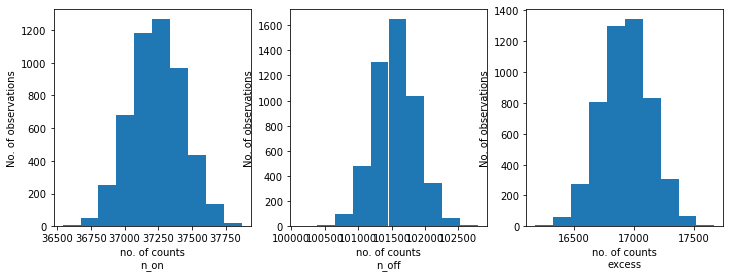

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
        }
    )

CPU times: user 5min 40s, sys: 1.08 s, total: 5min 41s
Wall time: 5min 41s


In [15]:
results

[{'index': 2.210312649457622, 'amplitude': 1.2999148010805192e-12},
 {'index': 2.221794649297089, 'amplitude': 1.2624720633438962e-12},
 {'index': 2.226917472297916, 'amplitude': 1.2692828741968535e-12},
 {'index': 2.2243294724809273, 'amplitude': 1.2760460667160836e-12},
 {'index': 2.230487848445283, 'amplitude': 1.289071814190189e-12},
 {'index': 2.2176425247166542, 'amplitude': 1.2822089037710306e-12},
 {'index': 2.216192794914367, 'amplitude': 1.2905649230744224e-12},
 {'index': 2.2181788794836295, 'amplitude': 1.2844505300569238e-12},
 {'index': 2.2148364595219476, 'amplitude': 1.2941866637630027e-12},
 {'index': 2.2099732084774226, 'amplitude': 1.3004987871954154e-12},
 {'index': 2.2172085439732427, 'amplitude': 1.3021990683930246e-12},
 {'index': 2.2163893701043262, 'amplitude': 1.3029965681849181e-12},
 {'index': 2.2152326224488714, 'amplitude': 1.3060639898614054e-12},
 {'index': 2.218580088362964, 'amplitude': 1.2638387722092008e-12},
 {'index': 2.216428727442129, 'amplitude'

index: 2.219973388150688 += 0.006576216200434388


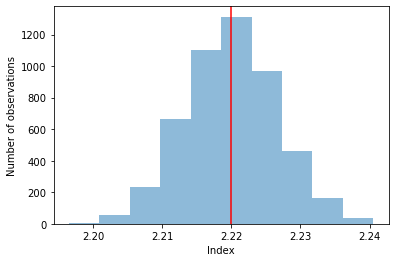

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2891522707555728e-12 += 1.4224331729249474e-14


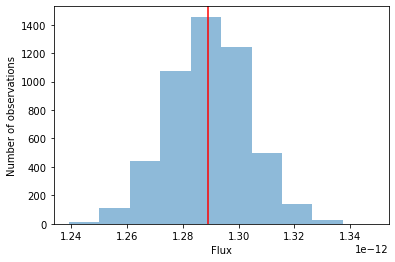

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")